In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Fix seed for reproducibility
np.random.seed(42)


In [29]:
# Discrete prices offered by the seller
PRICE_ARMS = np.array([5, 7, 9, 11, 13, 15])

# Number of customers
T = 5000


In [31]:
def sample_wtp():
    """
    Customer willingness-to-pay follows a skewed distribution.
    Most customers have moderate WTP, few have very high WTP.
    """
    wtp = np.random.normal(loc=9, scale=3)
    return max(0, wtp)


In [33]:
def customer_buys(price, wtp):
    """
    Purchase probability decays smoothly with price.
    Even if price <= WTP, purchase is not guaranteed.
    """
    purchase_prob = np.exp(-price / (wtp + 1e-6))
    return np.random.rand() < purchase_prob


In [35]:
def simulate_step(price):
    """
    Simulates one customer interaction.
    Returns revenue earned from that customer.
    """
    wtp = sample_wtp()
    if customer_buys(price, wtp):
        return price
    else:
        return 0


In [37]:
def compute_oracle_price(prices, trials=300000):
    """
    Computes the best fixed price assuming true demand is known.
    Used only as an evaluation upper bound.
    """
    avg_revenues = []
    
    for p in prices:
        total = 0
        for _ in range(trials):
            total += simulate_step(p)
        avg_revenues.append(total / trials)
    
    best_price = prices[np.argmax(avg_revenues)]
    best_revenue = np.max(avg_revenues)
    
    return best_price, best_revenue

oracle_price, oracle_revenue = compute_oracle_price(PRICE_ARMS)
oracle_price, oracle_revenue


(9, 3.1542)

In [39]:
def random_pricing(prices, T):
    """
    Chooses prices randomly.
    No learning involved.
    """
    rewards = []
    
    for _ in range(T):
        price = np.random.choice(prices)
        rewards.append(simulate_step(price))
    
    return np.cumsum(rewards)

random_rewards = random_pricing(PRICE_ARMS, T)


In [41]:
def epsilon_greedy(prices, T, epsilon=0.1):
    """
    Explores randomly with probability epsilon.
    Otherwise exploits the best-known price.
    """
    n_arms = len(prices)
    counts = np.zeros(n_arms)
    values = np.zeros(n_arms)
    rewards = []

    for _ in range(T):
        if np.random.rand() < epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(values)

        reward = simulate_step(prices[arm])
        
        counts[arm] += 1
        values[arm] += (reward - values[arm]) / counts[arm]
        rewards.append(reward)

    return np.cumsum(rewards)

eg_rewards = epsilon_greedy(PRICE_ARMS, T)


In [43]:
def ucb(prices, T, c=2):
    """
    Optimistic pricing using confidence bounds.
    """
    n_arms = len(prices)
    counts = np.zeros(n_arms)
    values = np.zeros(n_arms)
    rewards = []

    for t in range(T):
        if t < n_arms:
            arm = t
        else:
            confidence = c * np.sqrt(np.log(t + 1) / (counts + 1e-6))
            arm = np.argmax(values + confidence)

        reward = simulate_step(prices[arm])
        
        counts[arm] += 1
        values[arm] += (reward - values[arm]) / counts[arm]
        rewards.append(reward)

    return np.cumsum(rewards)

ucb_rewards = ucb(PRICE_ARMS, T)


In [45]:
def thompson_sampling(prices, T):
    """
    Thompson Sampling with Gaussian belief over revenue.
    """
    n_arms = len(prices)
    
    means = np.zeros(n_arms)
    variances = np.ones(n_arms)
    counts = np.zeros(n_arms)
    
    rewards = []

    for _ in range(T):
        samples = np.random.normal(means, np.sqrt(variances))
        arm = np.argmax(samples)

        reward = simulate_step(prices[arm])
        
        counts[arm] += 1
        means[arm] += (reward - means[arm]) / counts[arm]
        variances[arm] = max(1e-2, variances[arm] / counts[arm])
        
        rewards.append(reward)

    return np.cumsum(rewards)

ts_rewards = thompson_sampling(PRICE_ARMS, T)


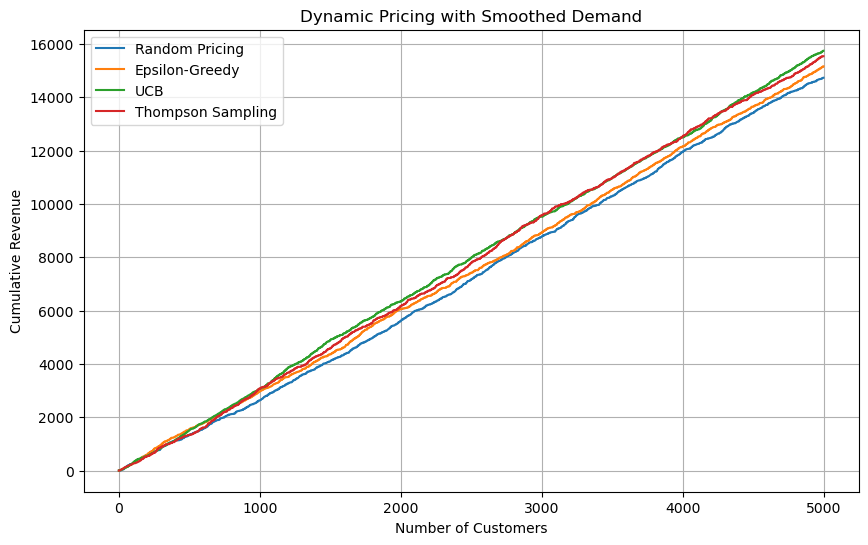

In [47]:
plt.figure(figsize=(10, 6))

plt.plot(random_rewards, label="Random Pricing")
plt.plot(eg_rewards, label="Epsilon-Greedy")
plt.plot(ucb_rewards, label="UCB")
plt.plot(ts_rewards, label="Thompson Sampling")

plt.xlabel("Number of Customers")
plt.ylabel("Cumulative Revenue")
plt.title("Dynamic Pricing with Smoothed Demand")
plt.legend()
plt.grid(True)
plt.show()


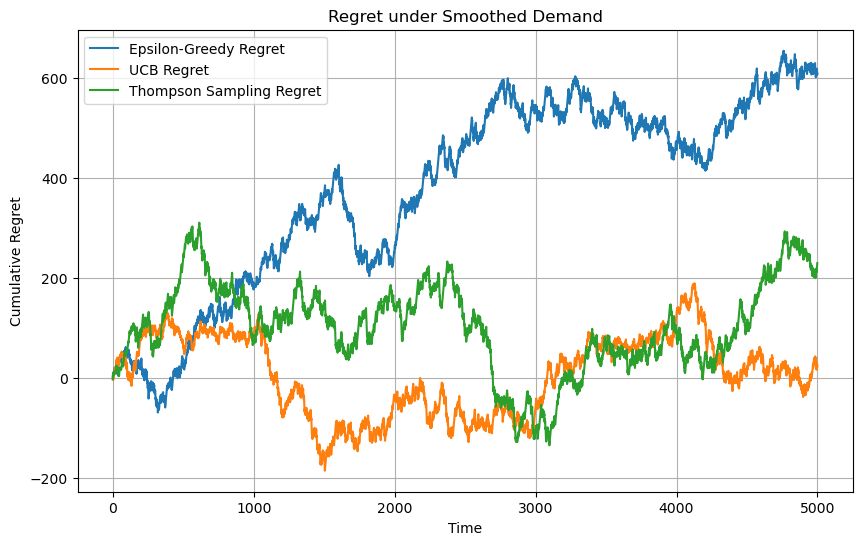

In [49]:
oracle_cumulative = oracle_revenue * np.arange(1, T + 1)

plt.figure(figsize=(10, 6))

plt.plot(oracle_cumulative - eg_rewards, label="Epsilon-Greedy Regret")
plt.plot(oracle_cumulative - ucb_rewards, label="UCB Regret")
plt.plot(oracle_cumulative - ts_rewards, label="Thompson Sampling Regret")

plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.title("Regret under Smoothed Demand")
plt.legend()
plt.grid(True)
plt.show()


In [51]:
print("Final revenue after", T, "customers:\n")

print(f"Random Pricing:        {random_rewards[-1]:.2f}")
print(f"Epsilon-Greedy:        {eg_rewards[-1]:.2f}")
print(f"UCB:                   {ucb_rewards[-1]:.2f}")
print(f"Thompson Sampling:     {ts_rewards[-1]:.2f}")
print(f"Oracle (Upper Bound):  {oracle_revenue * T:.2f}")


Final revenue after 5000 customers:

Random Pricing:        14734.00
Epsilon-Greedy:        15162.00
UCB:                   15746.00
Thompson Sampling:     15541.00
Oracle (Upper Bound):  15771.00


In [53]:
import os

# Create results directory
results_dir = "results_DP"
os.makedirs(results_dir, exist_ok=True)

# ---- Save revenue comparison plot ----
plt.figure(figsize=(10, 6))
plt.plot(random_rewards, label="Random Pricing")
plt.plot(eg_rewards, label="Epsilon-Greedy")
plt.plot(ucb_rewards, label="UCB")
plt.plot(ts_rewards, label="Thompson Sampling")
plt.xlabel("Number of Customers")
plt.ylabel("Cumulative Revenue")
plt.title("Dynamic Pricing with Smoothed Demand")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, "revenue_comparison.png"))
plt.close()

# ---- Save regret plot ----
oracle_cumulative = oracle_revenue * np.arange(1, T + 1)

plt.figure(figsize=(10, 6))
plt.plot(oracle_cumulative - eg_rewards, label="Epsilon-Greedy Regret")
plt.plot(oracle_cumulative - ucb_rewards, label="UCB Regret")
plt.plot(oracle_cumulative - ts_rewards, label="Thompson Sampling Regret")
plt.xlabel("Time")
plt.ylabel("Cumulative Regret")
plt.title("Regret Comparison")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_dir, "regret_comparison.png"))
plt.close()

# ---- Save final numerical results ----
with open(os.path.join(results_dir, "final_results.txt"), "w") as f:
    f.write("Final revenue after {} customers:\n\n".format(T))
    f.write(f"Random Pricing:        {random_rewards[-1]:.2f}\n")
    f.write(f"Epsilon-Greedy:        {eg_rewards[-1]:.2f}\n")
    f.write(f"UCB:                   {ucb_rewards[-1]:.2f}\n")
    f.write(f"Thompson Sampling:     {ts_rewards[-1]:.2f}\n")
    f.write(f"Oracle (Upper Bound):  {oracle_revenue * T:.2f}\n")

print("All results saved in 'results_DP/' folder.")

All results saved in 'results_DP/' folder.
